# Multiscale Markov State Models Example

In this tutorial, we will use **mMSM-Explore** to map a toy 1D energy landscape and build a **Multiscale Markov State Model (mMSM)** for it.

### Imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.misc import derivative
from mmsm.self_expanding_mmsm import SelfExpandingMultiscaleMSM
from mmsm.mmsm_config import mMSMConfig
from mmsm.mmsm_base.base_discretizer import BaseDiscretizer
from mmsm.mmsm_base.base_trajectory_sampler import BaseTrajectorySampler

We shall map the following 1D energy landscape:

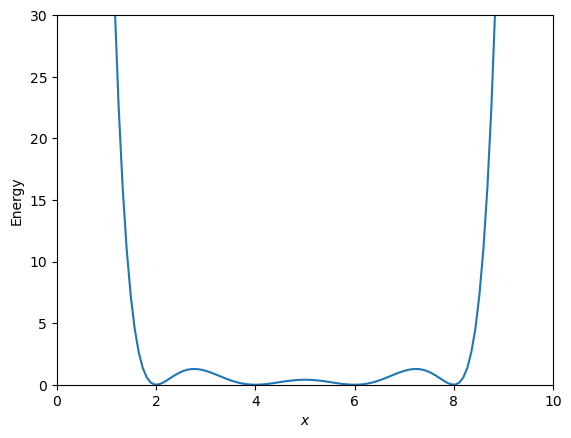

In [2]:
f = lambda x: 0.005 * (x - 2) ** 2 * (x - 4) ** 2 * (x - 6) ** 2 * (x - 8) ** 2
dfdx = lambda x: ((x - 8) * (x - 6) * (x - 4) * (x - 2) * (x ** 3 - 15 * x ** 2 + 70 * x - 100)) / 25

# fig, ax = plt.subplots(figsize=(12, 5))
plt.ylim(0, 30)
plt.xlim(0,10)
plt.xlabel("$x$")
plt.ylabel("Energy")
plt.plot(np.linspace(1, 9, 100), [f(x) for x in np.linspace(1, 9, 100)])
plt.show()

### Implemenating the simulator and discretizer

We first need to define a *simulator* and a *discretizer*.

Our simulator will simulate a Brownian dynamics trajectory along the energy landscape and generate a series of consecutive configurations, given some initial configuration.

The discretizer will take the series of system configurations in the $x$ space, and convert it to a series of discrete states. In this example, we divide the $x$ space into bins of equal length; each bin is assigned a unique integer index representing a discrete state.

In [3]:
class ToyTrajectorySampler(BaseTrajectorySampler):
    def __init__(self, f, dfdx, tau_0, init_state):
        self.f = f 
        self.dfdx = dfdx
        self.tau_0 = tau_0
        self.init_state = init_state
    
    @property
    def timestep_size(self):
        return self.tau_0

    def sample_from_states(self, states, sample_len, n_samples, sample_interval=1):
        trajs = []
        for s in states:
            for i in range(n_samples):
                x_cur = s
                temp_traj = [x_cur]
                for j in range(sample_len-1):
                    for step in range(sample_interval):
                        x_cur = self._step(x_cur)
                    temp_traj.append(x_cur)
                trajs.append(np.array(temp_traj))
        return trajs

    def get_initial_sample(self, sample_len, n_samples, sample_interval=1):
        return self.sample_from_states([self.init_state], sample_len, n_samples, sample_interval)

    def _step(self, x):
        return x - self.tau_0 * derivative(self.f, x, dx=1e-6) + np.sqrt(0.5 * self.tau_0) * np.random.normal(0, 1)


class ToyDiscretizer(BaseDiscretizer):
    def __init__(self, left, right, n_bins, representative_sample_size=10):
        super().__init__(representative_sample_size)
        self.left = left
        self.right = right
        self.n_bins = n_bins
        self.intervals = np.linspace(left, right, num=n_bins+1)

    @property
    def n_states(self):
        return self.n_bins

    def _coarse_grain_states(self, data : np.ndarray):
        return np.digitize(data, self.intervals) - 1

    def get_centers_by_ids(self, cluster_ids):
        return [(self.intervals[c] + self.intervals[c + 1]) / 2 for c in cluster_ids]

    def sample_from(self, cluster_id):
        return self.get_centers_by_ids([cluster_id])[0]

For visualization, we also define two helper functions:

In [4]:
def mmsm_to_nx(mmsm: SelfExpandingMultiscaleMSM):
    G = nx.DiGraph()
    G.add_nodes_from([v for h in range(mmsm.tree.height + 1) for v in mmsm.tree.get_level(h)])
    for h in range(mmsm.tree.height + 1):
        lvl_sd = mmsm.tree.get_level_stationary_distribution(h)
        for v_src in mmsm.tree.get_level(h):  # iterate over vertices
            t_out_ids, t_out = mmsm.tree.get_external_T(v_src)  # get the outgoing transitions of the vertex
            G.nodes[v_src]['p'] = lvl_sd[v_src]
            G.nodes[v_src]['h'] = h
            for dst_i, v_dst in enumerate(t_out_ids):
                G.add_edge(v_src, v_dst, p=t_out[dst_i])
            G.add_edge(mmsm.tree.get_parent(v_src), v_src)  # add edge from parent to this vertex
    return G

def visualize(mmsm: SelfExpandingMultiscaleMSM):
    mmsm_nx = mmsm_to_nx(mmsm)
    pos = dict()
    Y_START = 7
    Y_SPACING = 1.5
    free_en = {ms: -np.log(v) * 0.593 for ms, v in mmsm.tree.get_full_stationary_distribution().items()}
    free_en_C = np.min(list(free_en.values()))
    for h in range(mmsm.tree.height + 1):
        for v in mmsm.tree.get_level(h):
            if h == 0:  # position microstates according to their energy value
                pos_x = mmsm.discretizer.get_centers_by_ids([v])[0]
                pos_y = 0.593 * -np.log(mmsm_nx.nodes[v]['p']) - free_en_C
            else:  # all other nodes built hierarchically over the microstates
                pos_x = np.mean([pos[child][0] for child in mmsm.tree.vertices[v].children])
                pos_y = Y_START + Y_SPACING*(h-1)
            pos[v] = (pos_x, pos_y)
    
    
    # Selects only horizontal edges (between levels)
    edge_filter_h = lambda e: mmsm_nx.nodes[e[0]]['h'] != mmsm_nx.nodes[e[1]]['h']

    # Selects edges on the same level, excluding self edges and edges among microstates.
    edge_filter_v = lambda e: e[0] != e[1] and mmsm_nx.nodes[e[0]]['h'] == mmsm_nx.nodes[e[1]]['h'] and mmsm_nx.nodes[e[0]]['h'] != 0

    node_sizes = [5 + 195 * mmsm_nx.nodes[v]['p']**0.99 for v in mmsm_nx.nodes]
    edge_sizes = [(0.1 + (3 * mmsm_nx.edges[e]['p']**0.5))*mmsm_nx.nodes[e[0]]['h'] for e in mmsm_nx.edges if edge_filter_v(e)]
    
    fig, ax = plt.subplots(figsize=(12, 7))
    plt.ylim(0, np.maximum(25, Y_START + Y_SPACING*h))
    plt.xlim(0,10)
    nx.draw_networkx_nodes(mmsm_nx, pos=pos, ax=ax, node_size=node_sizes)
    nx.draw_networkx_edges(mmsm_nx, 
                           edgelist=[e for e in mmsm_nx.edges if edge_filter_h(e)], 
                           pos=pos, ax=ax, node_size=node_sizes, arrows=False, alpha=0.5, width=0.5, edge_color='gray')
    nx.draw_networkx_edges(mmsm_nx, 
                           edgelist=[e for e in mmsm_nx.edges if edge_filter_v(e)], 
                           pos=pos, ax=ax, node_size=node_sizes, width=edge_sizes, connectionstyle="arc3,rad=0.07")
    ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    ax.set_axis_on()
    plt.xlabel("$x$")
    plt.ylabel("Energy")
    plt.show()

### Running the simulation and visualizing the structure

We set the simulation to begin at $x=2$, and simulate at steps of $\tau_0=0.01$. The discretizer will divide the $[1,9]$ interval into 100 bins of equal lengths.

Calling `SelfExpandingMultiscaleMSM.expand` runs the mMSM-explore loop for a specified number of iterations. Each iteration (or “batch”) consists of `n_trajectories` trajectories of `trajectory_len` configurations.

In [5]:
sampler = ToyTrajectorySampler(f, dfdx, tau_0=0.01, init_state=2)
discretizer = ToyDiscretizer(left=1, right=9, n_bins=200)
cnfg = mMSMConfig(n_trajectories=2, trajectory_len=1000,
                  sampling_heuristics=['equilibrium', 'exploration'],
                  sampling_heuristic_weights=[0.5, 0.5])
toy_mmsm = SelfExpandingMultiscaleMSM(sampler, discretizer, config=cnfg)
toy_mmsm.expand(max_batches=1)

/home/nirn/Programs/miniconda/envs/ravehlabimp/lib/python3.9/site-packages/msmtools/analysis/dense/decomposition.py:549: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eigenvalues with non-zero imaginary part', ImaginaryEigenValueWarning)


Visualize the intermediate structure:

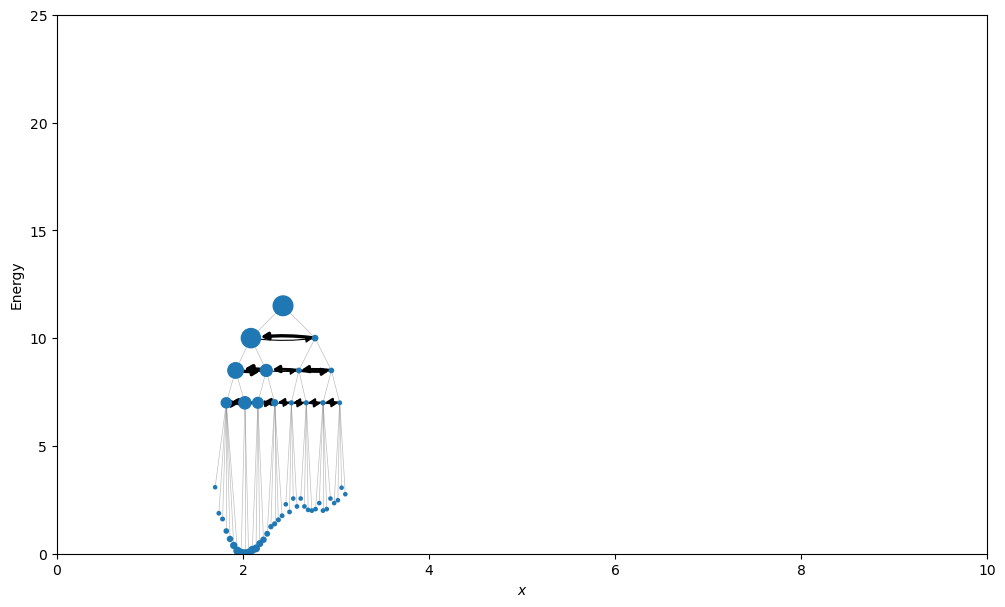

In [6]:
visualize(toy_mmsm)

This visualization displays all levels of the hiearachical structure, rom the microstates at the bottom to the root macrostate at the top. Microstates are plotted according to their energy values (estimated via Boltzmann inversion). At each higher level, macrostates form progressively coarser partitions of those microstates, culminating in a single root macrostate spanning the portion of $x$-space explored so far. Node sizes and edge widths indicate estimated stationary and transition probabilities, respectively.

After this short expansion, we likely observe that the leftmost basin is substantially explored, and that the model has begun crossing the energy barrier (results may vary due to the stochastic nature of the simulation). At lower levels of the hierarchy, macrostates represent small diffusion-limited regions, while higher levels group together entire basins separated by larger energy barriers.

To continue exploration, we can run several more batches and visualize again:

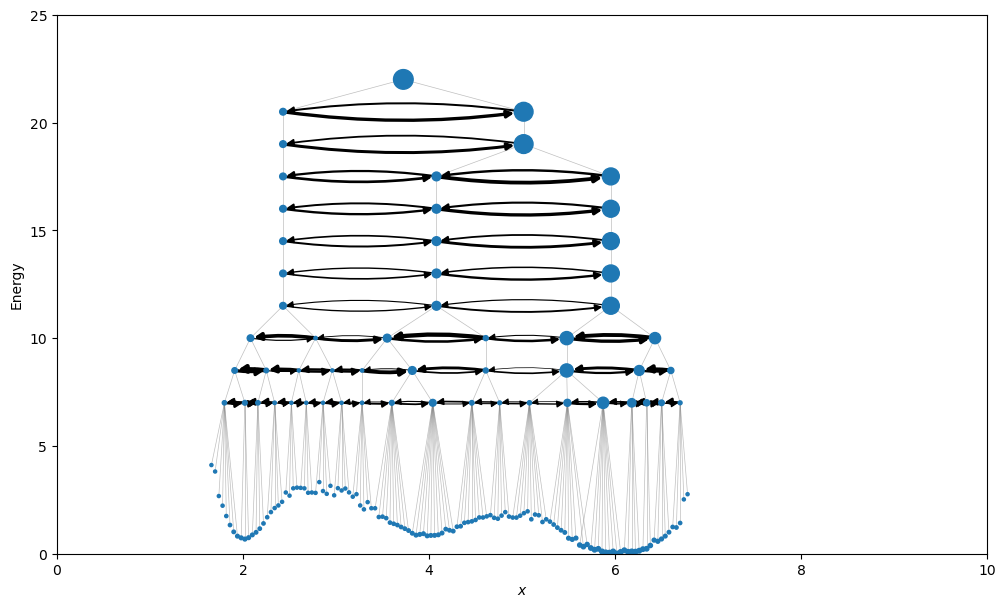

In [7]:
toy_mmsm.expand(max_batches=5)
visualize(toy_mmsm)

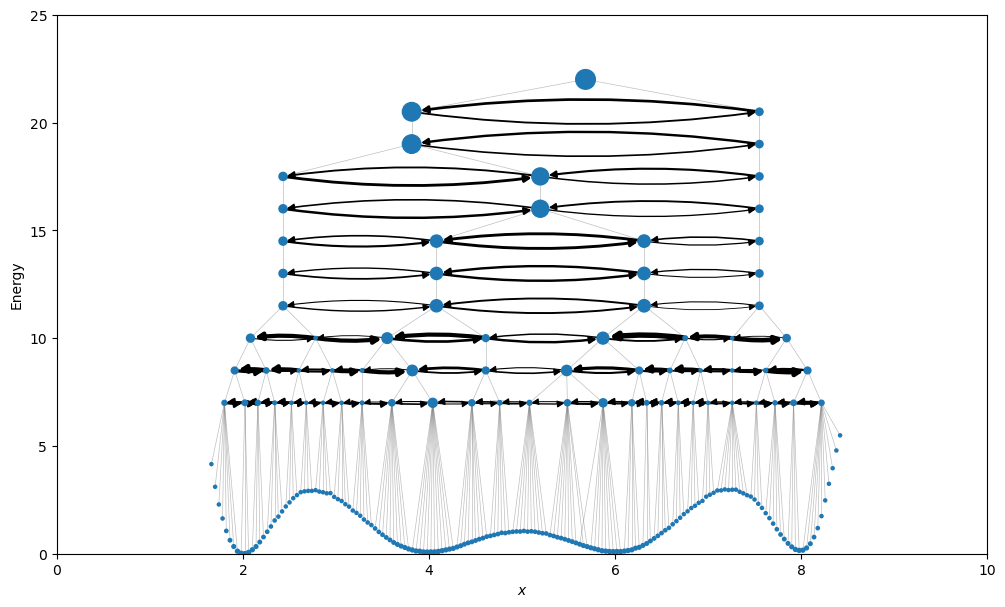

In [8]:
toy_mmsm.expand(max_batches=500)
visualize(toy_mmsm)

The final structure should cover the entire feasible configuration space. Each of the four energy basins should appear as a distinct macrostate at some hierarchy level, and the two center basins (separated by a smaller barrier) may merge into one macrostate at a higher level, which reflects a larger timescale.

---

### Further analysis

We can also run a naive simulation of the system and compare its empirical distribution with the microstate distribution from the mMSM:

In [ ]:
# Naive sim
n_bins = 200
naive_sampler = ToyTrajectorySampler(f, dfdx, tau_0=0.01, init_state=2)
hist = np.zeros(n_bins)
bin_edges = np.linspace(1, 9, n_bins+1)
last_config = 2
for i in range(10000):
    traj = naive_sampler.sample_from_states([last_config], 1000, 1)
    last_config = traj[0][-1]
    hist += np.histogram(traj, bins=n_bins, range=(1, 9))[0]

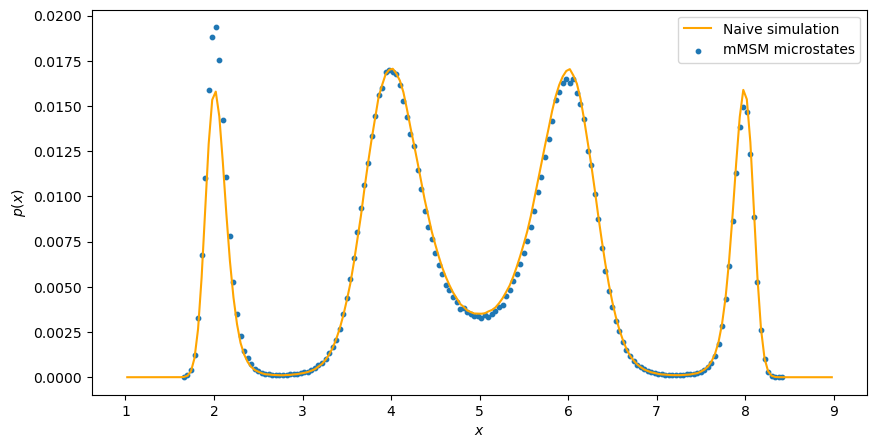

In [10]:
# Get the mMSM microstate distribution
sd = toy_mmsm.tree.get_level_stationary_distribution(0)
mmsm_sd = {toy_mmsm.discretizer.get_centers_by_ids([bin_id])[0]: p for bin_id, p in sd.items()}

# Plot
plt.figure(figsize=(10,5))
plt.plot([(bin_edges[b] + bin_edges[b + 1]) / 2 for b in range(n_bins)], hist / hist.sum(), label="Naive simulation", c="orange")
plt.scatter(list(mmsm_sd.keys()), list(mmsm_sd.values()), s=10, label="mMSM microstates")
plt.legend(loc='upper right')
plt.xlabel("$x$")
plt.ylabel("$p(x)$")
plt.show()